## Mask R-CNN - Inspect Weights of a Trained Model

This notebook includes code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import keras

import utils
import model as modellib
import visualize
from model import log

from config import Config

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()
/
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Path to Shapes trained weights
SHAPES_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_shapes.h5")

/home/shangyingao/miniconda3/envs/dl4cv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Configurations

In [2]:
class CityscapeConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "cityscape_data"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # Number of classes
    NUM_CLASSES = 35

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
#     IMAGE_MIN_DIM = 1024
#     IMAGE_MAX_DIM = 2048
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 1024

    # Use smaller anchors because our image and objects are small
    # RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 200  # default value

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100  # small number on small dataset, better smaller than 1000

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5  # bigger number improves validation stats accuracy but slows down
    
config = CityscapeConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  512
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           cityscape_data
NUM_CLASSES                    35
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRA

In [6]:
# Run one of the code blocks

# Shapes toy dataset
# import shapes
# config = shapes.ShapesConfig()

# MS COCO Dataset
# import coco
# config = coco.CocoConfig()

## Notebook Preferences

In [3]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

In [4]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Model

In [5]:
config.NAME

'cityscape_data'

# change: model path on first row

In [6]:
# Create model in inference mode
# CITY_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_cityscape_data_signal_image.h5")
CITY_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_cityscape_data_most_train.h5")



with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

# Set weights file path
if config.NAME == "shapes":
    weights_path = SHAPES_MODEL_PATH
elif config.NAME == "coco":
    weights_path = COCO_MODEL_PATH
elif config.NAME == 'cityscape_data':
    weights_path = CITY_MODEL_PATH

# Or, uncomment to load the last model you trained
# weights_path = model.find_last()[1]

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /home/shangyingao/WWGH/mask_rcnn_cityscape_data_most_train.h5


## Review Weight Stats

In [13]:
# Show stats of all trainable weights    
visualize.display_weight_stats(model)

WEIGHT NAME,SHAPE,MIN,MAX,STD
conv1_1/kernel:0,"(7, 7, 3, 64)",-0.8616,+0.8451,+0.1315
conv1_1/bias:0,"(64,)",-0.0002,+0.0004,+0.0001
bn_conv1_1/gamma:0,"(64,)",+0.0835,+2.6411,+0.5091
bn_conv1_1/beta:0,"(64,)",-2.3931,+5.3610,+1.9781
bn_conv1_1/moving_mean:0,"(64,)",-173.0470,+116.3013,+44.5654
bn_conv1_1/moving_variance:0*** Overflow?,"(64,)",+0.0000,+146335.3594,+21847.9668
res2a_branch2a_1/kernel:0,"(1, 1, 64, 64)",-0.6574,+0.3179,+0.0764
res2a_branch2a_1/bias:0,"(64,)",-0.0022,+0.0082,+0.0018
bn2a_branch2a_1/gamma:0,"(64,)",+0.2169,+1.8489,+0.4116
bn2a_branch2a_1/beta:0,"(64,)",-2.1180,+3.7332,+1.1786


# Histograms of Weights

TODO: cleanup this part

# change: plot last few layers

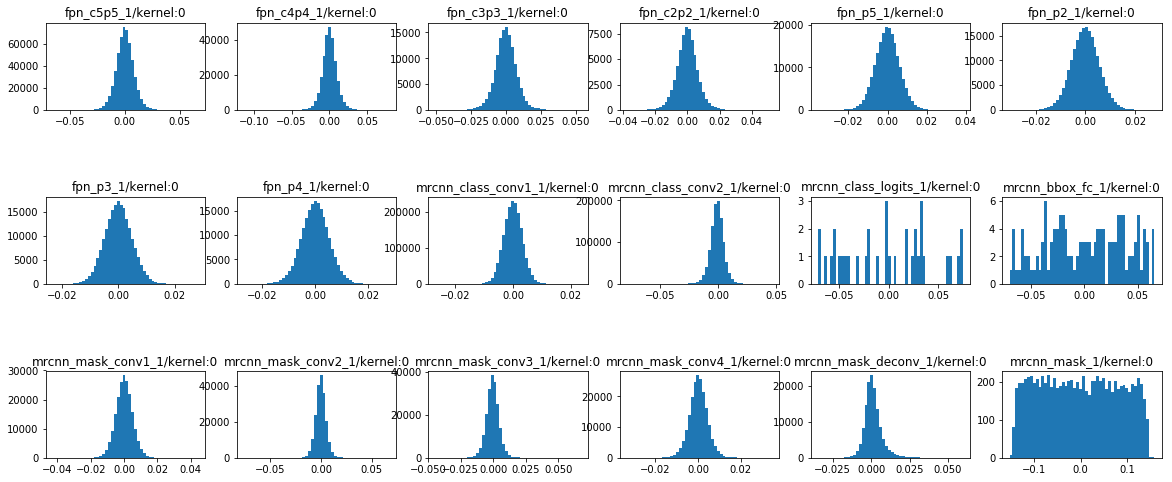

In [9]:
# Pick layer types to display
LAYER_TYPES = ['Conv2D', 'Dense', 'Conv2DTranspose']
# Get layers
layers = model.get_trainable_layers()[-25:]
layers = list(filter(lambda l: l.__class__.__name__ in LAYER_TYPES, 
                layers))
# layers = layers[:2]
# print(len(layers))
# Display Histograms
fig, ax = plt.subplots(3, 6, figsize=(20, 8),
                       gridspec_kw={"hspace":1})
for l, layer in enumerate(layers):
#     print(int(np.floor(5/6)), l%6)
    weights = layer.get_weights()
#     for w, weight in enumerate(weights):
    weight = weights[0]
    tensor = layer.weights[0]
    ax[int(np.floor(l/6)), l%6].set_title(tensor.name)
    _ = ax[int(np.floor(l/6)), l%6].hist(weight[0].flatten(), 50)



In [12]:
# Pick layer types to display
LAYER_TYPES = ['Conv2D', 'Dense', 'Conv2DTranspose']
# Get layers
layers = model.get_trainable_layers()
layers = list(filter(lambda l: l.__class__.__name__ in LAYER_TYPES, 
                layers))

In [18]:
len(layers)

122

In [ ]:
# Pick layer types to display
LAYER_TYPES = ['Conv2D', 'Dense', 'Conv2DTranspose']
# Get layers
layers = model.get_trainable_layers()
layers = list(filter(lambda l: l.__class__.__name__ in LAYER_TYPES, 
                layers))
# Display Histograms
fig, ax = plt.subplots(len(layers), 2, figsize=(10, 3*len(layers)),
                       gridspec_kw={"hspace":1})
for l, layer in enumerate(layers):
    weights = layer.get_weights()
    for w, weight in enumerate(weights):
        tensor = layer.weights[w]
        ax[l, w].set_title(tensor.name)
        _ = ax[l, w].hist(weight[w].flatten(), 50)

## the newst on large dataset / bad

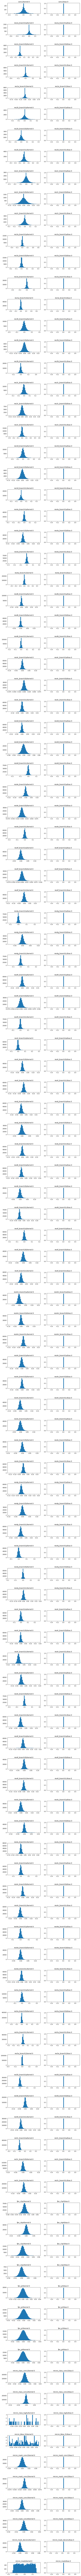

In [6]:
# Pick layer types to display
LAYER_TYPES = ['Conv2D', 'Dense', 'Conv2DTranspose']
# Get layers
layers = model.get_trainable_layers()
layers = list(filter(lambda l: l.__class__.__name__ in LAYER_TYPES, 
                layers))
# Display Histograms
fig, ax = plt.subplots(len(layers), 2, figsize=(10, 3*len(layers)),
                       gridspec_kw={"hspace":1})
for l, layer in enumerate(layers):
    weights = layer.get_weights()
    for w, weight in enumerate(weights):
        tensor = layer.weights[w]
        ax[l, w].set_title(tensor.name)
        _ = ax[l, w].hist(weight[w].flatten(), 50)


## best model on signal imge / bad

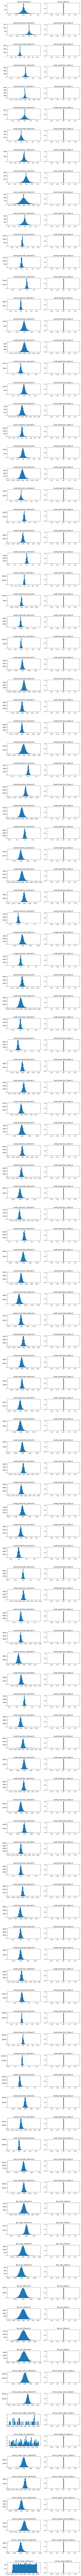

In [10]:
# Pick layer types to display
LAYER_TYPES = ['Conv2D', 'Dense', 'Conv2DTranspose']
# Get layers
layers = model.get_trainable_layers()
layers = list(filter(lambda l: l.__class__.__name__ in LAYER_TYPES, 
                layers))
# Display Histograms
fig, ax = plt.subplots(len(layers), 2, figsize=(10, 3*len(layers)),
                       gridspec_kw={"hspace":1})
for l, layer in enumerate(layers):
    weights = layer.get_weights()
    for w, weight in enumerate(weights):
        tensor = layer.weights[w]
        ax[l, w].set_title(tensor.name)
        _ = ax[l, w].hist(weight[w].flatten(), 50)

## most trained

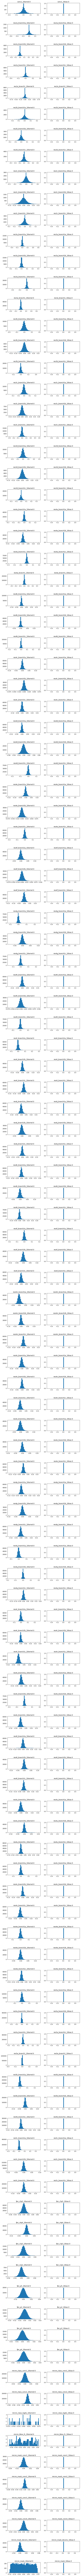

In [12]:
# Pick layer types to display
LAYER_TYPES = ['Conv2D', 'Dense', 'Conv2DTranspose']
# Get layers
layers = model.get_trainable_layers()
layers = list(filter(lambda l: l.__class__.__name__ in LAYER_TYPES, 
                layers))
# Display Histograms
fig, ax = plt.subplots(len(layers), 2, figsize=(10, 3*len(layers)),
                       gridspec_kw={"hspace":1})
for l, layer in enumerate(layers):
    weights = layer.get_weights()
    for w, weight in enumerate(weights):
        tensor = layer.weights[w]
        ax[l, w].set_title(tensor.name)
        _ = ax[l, w].hist(weight[w].flatten(), 50)